<a href="https://colab.research.google.com/github/juanmed/detectron2_instance_segmentation_demo/blob/master/Detectron2_custom_coco_data_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [ ]:
!python --version

Python 3.7.10


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [ ]:
!pip install gdown

In [ ]:
#import gdown
#import shutil
#https://drive.google.com/file/d/14ZcrZ9JbU8_XvCkGvq00xrZt2hioZjGv/view?usp=sharing
#url = 'https://drive.google.com/uc?id=14ZcrZ9JbU8_XvCkGvq00xrZt2hioZjGv'
#output = 'data.zip'
#gdown.download(url, output, quiet=False)

In [ ]:
#!unzip data.zip > /dev/null

In [ ]:
# Download test set
#https://drive.google.com/file/d/1IZpWoEfXUndLCVs0KWVnJxJuH0klxKUY/view?usp=sharing
#url = 'https://drive.google.com/uc?id=1IZpWoEfXUndLCVs0KWVnJxJuH0klxKUY'
#output = 'test.zip'
#gdown.download(url, output, quiet=False)

In [ ]:
#!unzip test.zip > /dev/null

In [ ]:
# Download full dataset
import gdown
import shutil
#https://drive.google.com/file/d/1CKo1ls81LEOBM-HDuauOT1_Tb1f3Bh2W/view?usp=sharing
url = 'https://drive.google.com/uc?id=1CKo1ls81LEOBM-HDuauOT1_Tb1f3Bh2W'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CKo1ls81LEOBM-HDuauOT1_Tb1f3Bh2W
To: /content/dataset.zip
7.25GB [02:29, 48.3MB/s]


'dataset.zip'

In [ ]:
!unzip dataset.zip > /dev/null

In [ ]:
!rm dataset.zip

In [ ]:
#download latest model
#ttps://drive.google.com/file/d/1lhBxaXSDzc8HaJFtXfLb9qcmS3VDyDnK/view?usp=sharing
url = "https://drive.google.com/uc?id=1lhBxaXSDzc8HaJFtXfLb9qcmS3VDyDnK"
output = 'model_final.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1lhBxaXSDzc8HaJFtXfLb9qcmS3VDyDnK
To: /content/model_final.pth
351MB [00:04, 72.2MB/s]


'model_final.pth'

In [ ]:
!mv model_final.pth output/

# Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("skku_unloading_coco_train", {}, "./train/train.json", "./train/")

In [ ]:
skku_train_metadata = MetadataCatalog.get("skku_unloading_coco_train")
skku_train_dataset_dicts = DatasetCatalog.get("skku_unloading_coco_train")

In [ ]:
register_coco_instances("skku_unloading_coco_test", {}, "./test/test.json", "./test/")
skku_test_metadata = MetadataCatalog.get("skku_unloading_coco_test")
skku_test_dataset_dicts = DatasetCatalog.get("skku_unloading_coco_test")

In [ ]:
register_coco_instances("skku_unloading_coco_val", {}, "./val/val.json", "./val/")
skku_val_metadata = MetadataCatalog.get("skku_unloading_coco_val")
skku_val_dataset_dicts = DatasetCatalog.get("skku_unloading_coco_val")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [ ]:
import random

for d in random.sample(skku_train_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=skku_train_metadata, scale=0.35)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [ ]:
#Prepare tensorboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


In [ ]:

LOG_DIR = '/content/output/'
print(LOG_DIR)
get_ipython().system_raw(
    'tensorboard --logdir --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')


/content/output/


In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://a1918aaa5191.ngrok.io


In [ ]:
!rm -rf output/*

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

# Evaluation code from
#https://github.com/facebookresearch/detectron2/issues/810#issuecomment-596194293

# More detailed implementation at
#https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
##or
#https://tshafer.com/blog/2020/06/detectron2-eval-loss

from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm
import torch
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


class MyTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
      output_folder = os.path.join(cfg.OUTPUT_DIR,"inference")
    return COCOEvaluator(dataset_name, cfg, True, output_folder)

class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))
        
    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)
            
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                 **loss_dict_reduced)

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("skku_unloading_coco_train",)
cfg.DATASETS.TEST = ("skku_unloading_coco_val",)   # no metrics implemented for this dataset
cfg.DATASETS.VAL = ("skku_unloading_coco_val",)   # no metrics implemented for this dataset
cfg.TEST.EVAL_PERIOD = 200
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 3000   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) #DefaultTrainer(cfg)
val_loss = ValidationLoss(cfg)  
trainer.register_hooks([val_loss])
# swap the order of PeriodicWriter and ValidationLoss
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=True)
trainer.train()

In [ ]:
!zip -r output.zip output
from google.colab import files
files.download('output.zip')

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("skku_unloading_coco_test", )
predictor = DefaultPredictor(cfg)

Do evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("skku_unloading_coco_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "skku_unloading_coco_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode
import random

for d in random.sample(skku_test_dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=skku_test_metadata, 
                   scale=0.4, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
skku_train_metadata

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

# Evaluate performance using pyCOCOtools

In [ ]:
!pip install pycocotools

In [ ]:
from pycocotools.coco import COCO 
from pycocotools.cocoeval import COCOeval 
import numpy as np 
import skimage.io as io 
import pylab,json 
from tempfile import NamedTemporaryFile

In [ ]:
def xyxy2xywh(bbox):
        """Convert ``xyxy`` style bounding boxes to ``xywh`` style for COCO
        evaluation.

        Args:
            bbox (numpy.ndarray): The bounding boxes, shape (4, ), in
                ``xyxy`` order.

        Returns:
            list[float]: The converted bounding boxes, in ``xywh`` order.
        """

        _bbox = bbox.tolist()
        return [
            _bbox[0],
            _bbox[1],
            _bbox[2] - _bbox[0],
            _bbox[3] - _bbox[1],
        ] 

import numpy as np                                 # (pip install numpy)
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)

def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd, bbox):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')

    segmentations = []
    polygons = []
    #print(len(contours))
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        if len(segmentation) > 4:
          segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    #x, y, max_x, max_y = multi_poly.bounds
    #width = max_x - x
    #height = max_y - y
    #bbox = (x, y, width, height)
    area = multi_poly.area

    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': category_id,
        'id': annotation_id,
        'bbox': bbox,
        'area': area
    }

    return segmentations

In [ ]:
# format all outputs into a list of dicts compatible with COCO

import pycocotools.mask as mask_util

#instances = outputs['instances']
#instances.pred_masks_rle = [mask_util.encode(np.asfortranarray(mask)) for mask in instances.pred_masks]
#for rle in instances.pred_masks_rle:
#    rle['counts'] = rle['counts'].decode('utf-8')
#instances.remove('pred_masks')

# TO TEST INVERT CONVERSION
#instances.pred_masks = np.stack([mask_util.decode(rle) for rle in instances.pred_masks_rle])

#Inspired from
# https://www.immersivelimit.com/create-coco-annotations-from-scratch

detection_res = []
is_crowd = 0
for k, d in enumerate(skku_test_dataset_dicts):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    outputs = outputs["instances"].to("cpu")

    bboxes = outputs.pred_boxes
    scores = outputs.scores
    classes = outputs.pred_classes
    masks = outputs.pred_masks
 
    #print("Image: ",k,"has {} masks".format(masks.shape[0]))

    #for i,(bbox, score, class_) in enumerate(zip(bboxes, scores, classes)):
    #  #print(i,bbox.tolist(), score.item(), class_.item(), d["image_id"])
    #  annotations = []
    #  for j, mask in enumerate(masks):
    #    #category_id = category_ids[image_id][color]
    #    annotation = create_sub_mask_annotation(mask, d["image_id"], class_, j, is_crowd, xyxy2xywh(bbox))
    #    annotations.append(annotation)
    #  #annotation_id += 1
    #  #image_id += 1


    for i,(bbox, score, class_, mask) in enumerate(zip(bboxes, scores, classes, masks)):

      annotation = create_sub_mask_annotation(mask, d["image_id"], class_, i, is_crowd, xyxy2xywh(bbox))
      #annotations.append(annotation)

      detection_res.append({
          'score': score.item(),
          'category_id': class_.item(),
          'bbox': xyxy2xywh(bbox),
          'image_id': d["image_id"],
          'segmentation': annotation
      })

In [ ]:
# json file in coco format, original annotation data
anno_file = '/content/test/test.json'
coco_gt = COCO(anno_file)
 
 # Use GT box as prediction box for calculation, the purpose is to get detection_res

"""
detection_res = []
with open(anno_file, 'r') as f:
    json_file = json.load(f)
annotations = json_file['annotations']
detection_res = []
for i, anno in enumerate(annotations):
    detection_res.append({
        'score': 1,
        'category_id': anno['category_id'],
        'bbox': anno['bbox'],
        'image_id': anno['image_id']
    })
    if i < 1 :
      print( anno['category_id'], anno['image_id'])
"""
 
with NamedTemporaryFile(suffix='.json') as tf:
         # Due to subsequent needs, first convert detection_res to binary and then write it to the json file
    content = json.dumps(detection_res).encode(encoding='utf-8')
    tf.write(content)
    res_path = tf.name
 
         # loadRes will generate a new COCO type instance based on coco_gt and return
    coco_dt = coco_gt.loadRes(res_path)
 
    cocoEval = COCOeval(coco_gt, coco_dt, 'bbox')  # use 'bbox' for bbox mAP or 'segm' for instance segmentation mAP
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
 
print(cocoEval.stats)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.74s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [ ]:
#mAP
mean_ap = cocoEval.stats[0].item()  # stats[0] records AP@[0.5:0.95]
print("mAP: ", mean_ap)

In [ ]:
print(coco_gt.getAnnIds())

103
dict_keys(['data_time', 'eta_seconds', 'fast_rcnn/cls_accuracy', 'fast_rcnn/false_negative', 'fast_rcnn/fg_cls_accuracy', 'iteration', 'loss_box_reg', 'loss_cls', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc', 'lr', 'mask_rcnn/accuracy', 'mask_rcnn/false_negative', 'mask_rcnn/false_positive', 'roi_head/num_bg_samples', 'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors', 'time', 'total_loss', 'total_val_loss', 'val_loss_box_reg', 'val_loss_cls', 'val_loss_mask', 'val_loss_rpn_cls', 'val_loss_rpn_loc'])


ValueError: ignored

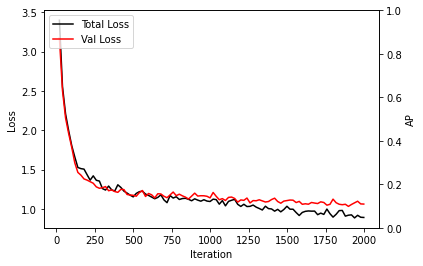

In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = './output/'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
print(len(experiment_metrics))
print(experiment_metrics[0].keys())

ax1.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x], color="black", label="Total Loss")
ax1.plot(
    [x['iteration'] for x in experiment_metrics if 'total_val_loss' in x], 
    [x['total_val_loss'] for x in experiment_metrics if 'total_val_loss' in x], color="red", label="Val Loss")
    
ax1.tick_params(axis='y')
plt.legend(loc='upper left')

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('AP')
ax2.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['bbox/AP'] for x in experiment_metrics if 'bbox/AP' in x], color=color, label="AP")
ax2.tick_params(axis='y')

plt.legend(loc='upper right')
plt.show()
